In [1]:
# environment: thesisPlayground_pointClouds_env

In [14]:
import h5py
import numpy as np
import open3d as o3d
import pandas as pd
import glob
import os

In [15]:
base_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes'
scene = 'ai_007_008'  # name of the scene, with format ai_VVV_NNN
cam_xx = 'cam_00'

path_metadata_camera_parameters = '/local/home/gmarsich/Desktop/Thesis/0Code_playground/pointClouds/pointClouds_ChatGPT/withDepths/metadata_camera_parameters.csv'
path_metadata_scene = os.path.join(base_path, scene, '_detail', 'metadata_scene.csv')
path_orientations = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_orientations.hdf5')
path_positions = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_positions.hdf5')

In [16]:
def euclidean_to_depth(path_distanceMatrix, intWidth, intHeight, fltFocal_mm, path_metadata_scene):
    """
    Converts Euclidean distances to depth values using the provided perspective projection matrix and camera parameters.
    
    Args:
    - distance_matrix (np.array): 2D array where each cell contains the Euclidean distance value.
    - P (np.array): 4x4 perspective projection matrix.
    - intWidth (int): Image width.
    - intHeight (int): Image height.
    - fltFocal (float): Focal length of the camera in millimeters
    
    Returns:
    - depth_matrix (np.array): 2D array where each cell contains the depth value (distance from image plane).
    """

    data_frame = pd.read_csv(path_metadata_scene)
    meters_per_asset_unit = data_frame.loc[data_frame['parameter_name'] == 'meters_per_asset_unit', 'parameter_value'].values[0]
    fltFocal = fltFocal_mm/meters_per_asset_unit

    with h5py.File(path_distanceMatrix, 'r') as file:
        # Access the dataset and read the data
        dataset = file['dataset']
        data = dataset[:]
        
        # Define the list of 2D points (row, column) to get the depth values for
        points = [(y, x) for y in range(intHeight) for x in range(intWidth)]
        
        # Get the depth values for the specified points
        distance_matrix = [data[y, x] for y, x in points]
        npyImageplaneX = np.linspace((-0.5 * intWidth) + 0.5, (0.5 * intWidth) - 0.5, intWidth).reshape(1, intWidth).repeat(intHeight, 0).astype(np.float32)[:, :, None]
        npyImageplaneY = np.linspace((-0.5 * intHeight) + 0.5, (0.5 * intHeight) - 0.5, intHeight).reshape(intHeight, 1).repeat(intWidth, 1).astype(np.float32)[:, :, None]
        npyImageplaneZ = np.full([intHeight, intWidth, 1], fltFocal, np.float32)
        npyImageplane = np.concatenate([npyImageplaneX, npyImageplaneY, npyImageplaneZ], 2)

        distance_matrix = np.array(distance_matrix)
        distance_matrix = distance_matrix.reshape(768, 1024)

        depth_matrix = distance_matrix / np.linalg.norm(npyImageplane, 2, 2) * fltFocal

        # Conversion meters -> asset units
        depth_matrix = depth_matrix / meters_per_asset_unit
        
        return depth_matrix

In [17]:
depthEuclidean_paths = os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_geometry_hdf5', 'frame.0001.depth_meters.hdf5')
depth_file = euclidean_to_depth(depthEuclidean_paths, intWidth=1024, intHeight=768, fltFocal_mm=48.30445098876953, path_metadata_scene=path_metadata_scene)

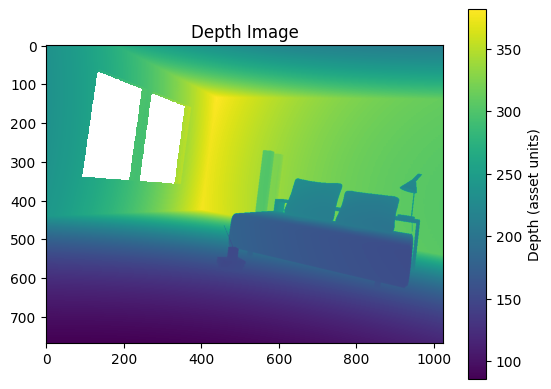

In [7]:
# TEST on one image
import matplotlib.pyplot as plt

plt.imshow(depth_file, cmap='viridis')  # Choose a colormap suitable for depth visualization
plt.colorbar(label='Depth (asset units)')  # Add a colorbar to show depth values
plt.title('Depth Image')  # Add a title to the plot
plt.show()

DA FARE:

Sperando che la trasformazione a distanza dal piano sia giutsa, prova a usare le coordinate qui scritte: https://github.com/apple/ml-hypersim/issues/10

x = u / fx * depth

y = v / fy * depth 

z = - depth


poi c'e' da fare la trasformazione che ha menzionato Mike:

equation 1: I'm assuming that the "camera orientation" matrix is R0, and the "camera position" vector is T0
xyz_world0 == (R0 * xyz_cam0) + T0

In [26]:
def get_P(path_metadata_camera_parameters, scene):
    df_camera_parameters = pd.read_csv(path_metadata_camera_parameters, index_col="scene_name")
    df_ = df_camera_parameters.loc[scene]

    M_proj = np.matrix([[ df_["M_proj_00"], df_["M_proj_01"], df_["M_proj_02"], df_["M_proj_03"] ],
                 [ df_["M_proj_10"], df_["M_proj_11"], df_["M_proj_12"], df_["M_proj_13"] ],
                 [ df_["M_proj_20"], df_["M_proj_21"], df_["M_proj_22"], df_["M_proj_23"] ],
                 [ df_["M_proj_30"], df_["M_proj_31"], df_["M_proj_32"], df_["M_proj_33"] ]])
    
    return M_proj

In [27]:
from scipy.linalg import rq

def decompose_projection_matrix(P):
    """
    Decomposes the 4x4 perspective projection matrix into intrinsic matrix K,
    rotation matrix R, and translation vector t.
    
    Args:
    - P (np.array): 4x4 perspective projection matrix.
    
    Returns:
    - K (np.array): 3x3 intrinsic matrix.
    - R (np.array): 3x3 rotation matrix.
    - t (np.array): 3x1 translation vector.
    """
    M = P[:3, :3]
    K, R = rq(M)
    
    # Normalize K to ensure K[2, 2] is 1
    K /= K[2, 2]
    
    t = np.linalg.inv(K).dot(P[:3, 3])
    
    return K, R, t

In [28]:
def depth_to_point_cloud(depth_matrix, P):
    """
    Converts a depth matrix (Euclidean distances) to a point cloud using a perspective projection matrix.

    Args:
    - depth_matrix (np.array): 2D array where each cell contains the depth value.
    - P (np.array): 4x4 perspective projection matrix.

    Returns:
    - point_cloud (np.array): Nx3 array of 3D points.
    """
    # Invert the perspective projection matrix
    P_inv = np.linalg.inv(P)

    K, R, t = decompose_projection_matrix(P)

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]

    print("Value of fx:", fx)
    print("Value of fy:", fy)
    print("Value of cx:", cx)
    print("Value of cy:", cy)

    height, width = depth_matrix.shape
    point_cloud = []

    for i in range(height):
        for j in range(width):
            D_ij = depth_matrix[i, j]
            if D_ij > 0:  # Consider only valid depth values
                # Convert Euclidean distance to Z_c
                Z_c = D_ij         
               
                # Compute X_c and Y_c
                X_c = (j - cx) * Z_c / fx
                Y_c = (i - cy) * Z_c / fy
                
                # Convert to homogeneous coordinates
                homogeneous_point = np.array([X_c, Y_c, Z_c, 1])
                
                # Transform to world coordinates
                world_point_homogeneous = np.dot(P_inv, homogeneous_point)
                X_w = world_point_homogeneous[0, 0]
                Y_w = world_point_homogeneous[0, 1]
                Z_w = world_point_homogeneous[0, 2]
                W_w = world_point_homogeneous[0, 3]
                world_point = np.array([X_w / W_w, Y_w / W_w, Z_w / W_w])
                
                point_cloud.append(world_point)
    
    return np.array(point_cloud)

In [35]:
P = get_P(path_metadata_camera_parameters, scene)
point_cloud = depth_to_point_cloud(depth_file, P)

Value of fx: 1.7230850325988878
Value of fy: 2.2974467101318505
Value of cx: 0.0
Value of cy: 0.18379573270239305


In [38]:
print(point_cloud)

[[-0.00000000e+00  6.96476849e-02  1.41286627e-02]
 [-6.75822532e-01  6.96474634e-02  1.41222447e-02]
 [-1.35164077e+00  6.96472422e-02  1.41158352e-02]
 ...
 [-6.92999667e+02 -2.91833926e+02 -2.33294556e+01]
 [-6.93675462e+02 -2.91832685e+02 -2.33293649e+01]
 [-6.94351256e+02 -2.91831446e+02 -2.33292743e+01]]


In [37]:
# Create an Open3D PointCloud object from the NumPy array
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])